In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
from comparers import ModelComparer
import matplotlib.pyplot as plt
from IPython.display import display
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate_counterfactual_fidelity, print_complexity
from surrogate_tree import train_surrogate_tree, tree_to_rules, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances, plot_tree_leafs_for_class,\
                 tree_to_constraint_matrix, constraint_matrix_to_rules, extract_rules, print_rules,\
                 evaluate
from tasks.boston_housing import make_task3 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


# Explanations

In [16]:
mclass_diff = comparer.predict_mclass_diff(X)

In [20]:
ground_truth_per_class = {}
for label in comparer.difference_class_names:
    with open(f'ground_truth.{label}.pickle', 'rb') as f:
        ground_truth_per_class[label] = pickle.load(f)

Trees with depths below 7 are not complex enough to describe all instances of the difference classes.

In [10]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=2)
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.86      0.86      0.86        76
      (0, 1)       0.00      0.00      0.00        13
      (1, 1)       0.65      0.95      0.77        58
      (1, 2)       0.00      0.00      0.00         1
      (2, 1)       0.00      0.00      0.00         3
      (2, 2)       0.98      0.88      0.93        95

    accuracy                           0.83       246
   macro avg       0.41      0.45      0.43       246
weighted avg       0.80      0.83      0.81       246

CPU times: user 12.4 ms, sys: 2.92 ms, total: 15.3 ms
Wall time: 16.2 ms


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [11]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=3)
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.90      0.96      0.93        76
      (0, 1)       0.60      0.23      0.33        13
      (1, 1)       0.89      0.97      0.93        58
      (1, 2)       0.00      0.00      0.00         1
      (2, 1)       0.00      0.00      0.00         3
      (2, 2)       0.97      0.99      0.98        95

    accuracy                           0.92       246
   macro avg       0.56      0.52      0.53       246
weighted avg       0.89      0.92      0.90       246

CPU times: user 11.3 ms, sys: 3.12 ms, total: 14.4 ms
Wall time: 17.6 ms


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [12]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=4)
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.93      0.97      0.95        76
      (0, 1)       0.83      0.38      0.53        13
      (1, 1)       0.90      0.98      0.94        58
      (1, 2)       0.00      0.00      0.00         1
      (2, 1)       0.75      1.00      0.86         3
      (2, 2)       1.00      0.98      0.99        95

    accuracy                           0.94       246
   macro avg       0.74      0.72      0.71       246
weighted avg       0.94      0.94      0.94       246

CPU times: user 12.3 ms, sys: 3.36 ms, total: 15.7 ms
Wall time: 16.5 ms


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [13]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=5)
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.99      0.99      0.99        76
      (0, 1)       0.85      0.85      0.85        13
      (1, 1)       0.97      0.97      0.97        58
      (1, 2)       1.00      1.00      1.00         1
      (2, 1)       1.00      1.00      1.00         3
      (2, 2)       1.00      1.00      1.00        95

    accuracy                           0.98       246
   macro avg       0.97      0.97      0.97       246
weighted avg       0.98      0.98      0.98       246

CPU times: user 9.07 ms, sys: 2.13 ms, total: 11.2 ms
Wall time: 12.9 ms


In [14]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=6)
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.97      1.00      0.99        76
      (0, 1)       1.00      0.92      0.96        13
      (1, 1)       1.00      0.98      0.99        58
      (1, 2)       1.00      1.00      1.00         1
      (2, 1)       1.00      1.00      1.00         3
      (2, 2)       1.00      1.00      1.00        95

    accuracy                           0.99       246
   macro avg       1.00      0.98      0.99       246
weighted avg       0.99      0.99      0.99       246

CPU times: user 10.6 ms, sys: 2.1 ms, total: 12.7 ms
Wall time: 14.6 ms


## Tree with Depth 7

In [15]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=7)
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.99      1.00      0.99        76
      (0, 1)       1.00      1.00      1.00        13
      (1, 1)       1.00      0.98      0.99        58
      (1, 2)       1.00      1.00      1.00         1
      (2, 1)       1.00      1.00      1.00         3
      (2, 2)       1.00      1.00      1.00        95

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246

CPU times: user 10.4 ms, sys: 2.49 ms, total: 12.9 ms
Wall time: 14.1 ms


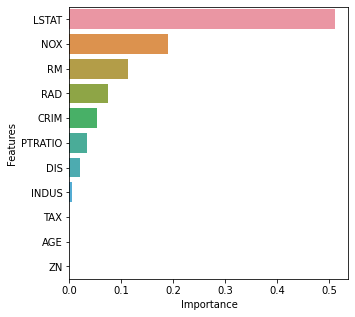

In [18]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

In [34]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. CRIM <= 0.9839633405208588 and NOX > 0.5909999907016754 and RM <= 6.0940001010894775 and 12.607422828674316 < LSTAT <= 17.722667694091797 => (0, 1) [0, 4, 0, 0, 0, 0]
2. 0.5909999907016754 < NOX <= 0.6180000007152557 and 9.477545261383057 < LSTAT <= 12.607422828674316 => (0, 1) [0, 3, 0, 0, 0, 0]
3. CRIM <= 1.4226450324058533 and NOX <= 0.5909999907016754 and PTRATIO > 20.600000381469727 and LSTAT > 17.515000343322754 => (0, 1) [0, 2, 0, 0, 0, 0]
4. 0.5309999883174896 < NOX <= 0.5909999907016754 and DIS > 2.271081805229187 and 16.715493202209473 < LSTAT <= 17.515000343322754 => (0, 1) [0, 2, 0, 0, 0, 0]
5. CRIM <= 5.023024320602417 and NOX <= 0.7439999878406525 and RM <= 6.61963152885437 and RAD > 6.0 and LSTAT <= 9.477545261383057 => (2, 1) [0, 0, 0, 0, 2, 0]
6. CRIM > 0.9839633405208588 and NOX > 0.5909999907016754 and RM > 5.949499845504761 and 12.607422828674316 < LSTAT <= 14.309999942779541 => (0, 1) [0, 1, 0, 0, 0, 0]
7. NOX <= 0.5909999907016754 and DIS > 2.271081805229187 an

## Evaluation

### Global Fidelity

In [27]:
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.99      1.00      0.99        76
      (0, 1)       1.00      1.00      1.00        13
      (1, 1)       1.00      0.98      0.99        58
      (1, 2)       1.00      1.00      1.00         1
      (2, 1)       1.00      1.00      1.00         3
      (2, 2)       1.00      1.00      1.00        95

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



### Counterfactual Fidelity Error

#### (0, 1)

In [35]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [38]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule_focus, constraints_focus)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [39]:
rmse

CRIM       0.794867
ZN              NaN
INDUS           NaN
NOX             NaN
RM              NaN
AGE             NaN
DIS             NaN
RAD        2.470000
TAX             NaN
PTRATIO    0.432782
LSTAT      1.602040
dtype: float64

In [40]:
boundary_miss_rate

CRIM       0.631579
ZN         1.000000
INDUS      1.000000
NOX             NaN
RM         1.000000
AGE        1.000000
DIS        1.000000
RAD        0.937500
TAX        1.000000
PTRATIO    0.833333
LSTAT      0.076923
dtype: float64

In [41]:
boundary_add_rate

CRIM       0.0
ZN         NaN
INDUS      NaN
NOX        1.0
RM         1.0
AGE        NaN
DIS        1.0
RAD        0.0
TAX        NaN
PTRATIO    0.0
LSTAT      0.0
dtype: float64

#### (1, 2)

In [43]:
focus_class_idx, focus_class = comparer.check_class('(1, 2)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [44]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule_focus, constraints_focus)

In [45]:
rmse

CRIM            NaN
ZN              NaN
INDUS           NaN
NOX             NaN
RM         1.120368
AGE             NaN
DIS             NaN
RAD        6.720000
TAX             NaN
PTRATIO         NaN
LSTAT      0.015000
dtype: float64

In [46]:
boundary_miss_rate

CRIM       1.0
ZN         1.0
INDUS      1.0
NOX        NaN
RM         0.5
AGE        1.0
DIS        1.0
RAD        0.5
TAX        NaN
PTRATIO    1.0
LSTAT      0.5
dtype: float64

In [47]:
boundary_add_rate

CRIM       1.0
ZN         NaN
INDUS      NaN
NOX        NaN
RM         0.0
AGE        NaN
DIS        NaN
RAD        0.0
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

#### (2, 1)

In [48]:
focus_class_idx, focus_class = comparer.check_class('(2, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [49]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule_focus, constraints_focus)

In [50]:
rmse

CRIM        4.981600
ZN               NaN
INDUS            NaN
NOX              NaN
RM          1.361463
AGE              NaN
DIS              NaN
RAD        11.720004
TAX              NaN
PTRATIO          NaN
LSTAT       1.746977
dtype: float64

In [51]:
boundary_miss_rate

CRIM       0.5
ZN         1.0
INDUS      1.0
NOX        NaN
RM         0.4
AGE        1.0
DIS        1.0
RAD        0.5
TAX        1.0
PTRATIO    1.0
LSTAT      0.5
dtype: float64

In [52]:
boundary_add_rate

CRIM       0.333333
ZN              NaN
INDUS           NaN
NOX        1.000000
RM         0.000000
AGE             NaN
DIS             NaN
RAD        0.000000
TAX             NaN
PTRATIO    1.000000
LSTAT      0.000000
dtype: float64

### Complexity

#### (0, 1)

In [59]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [60]:
print_complexity(constraints_focus)

Number of rules: 6
Number of constraints: 29 (4.8 per rule)


#### (1, 2)

In [61]:
focus_class_idx, focus_class = comparer.check_class('(1, 2)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [62]:
print_complexity(constraints_focus)

Number of rules: 1
Number of constraints: 4 (4.0 per rule)


#### (2, 1)

In [63]:
focus_class_idx, focus_class = comparer.check_class('(2, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [64]:
print_complexity(constraints_focus)

Number of rules: 2
Number of constraints: 9 (4.5 per rule)
